In [2]:
import pystan
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
import arviz as az

# Coin Toss

How can we be sure a coin toss is fair? A bayesian approach would require us to choose a prior distribution for theta. Theta in this example represents the probability of landing a heads. Moreover, we need a distrbution that we think y follows. In this case, y is a bernoulli trial.

Our posterior is proportional to: likelihood * prior

prior: beta(5,5) -> this is because we'd like the distribution of beta to be symmetrical around 0.5

The graph below shows a beta(5,5) distribution of theta and 10,000 samples are drawn and plotted. As we can see, the graph is symmetric around 0.5. This means, our prior distribution gives us an average value of theta of 0.5 (our prior belief being that the coin is indeed fair).

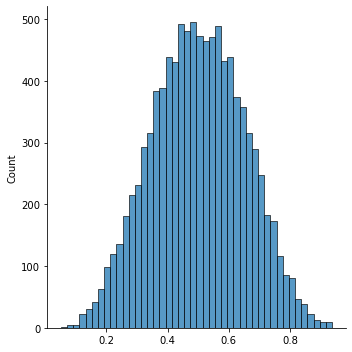

In [4]:
sns.displot(np.random.beta(5,5, size=10000),kde=False)

# pystan to calculate posterior

**data**: corresponds to the data of our model. In this case, the integer N corresponds to the number of coin tosses, and y corresponds to a vector of integers of length N that will contain the observations of our experiment.

**parameters**: correspond to the parameters of our model, in this case theta, or the probability of obtaining “Heads”

**model**: corresponds to the definition of our prior (beta) and likelihood (bernoulli).


In our example, lets say we flipped the coin 4 times (N=4) and we observed all tails (y=[0,0,0,0]). What would our posterior distribution tell us?

In [5]:
# bernoulli model
model_code = """
    data {
      int<lower=0> N;
      int<lower=0,upper=1> y[N];
    }
    parameters {
      real<lower=0,upper=1> theta;
    }
    model {
      theta ~ beta(5, 5);
      for (n in 1:N)
          y[n] ~ bernoulli(theta);
    }
    """
data = dict(N=4, y=[0, 0, 0, 0])
model = pystan.StanModel(model_code=model_code)
fit = model.sampling(data=data,iter=4000, chains=4, warmup=1000)
la = fit.extract(permuted=True)  # return a dictionary of arrays
print(fit.stansummary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d3835c4370ff5e66f1e88bd3eac647ff NOW.


Inference for Stan model: anon_model_d3835c4370ff5e66f1e88bd3eac647ff.
4 chains, each with iter=4000; warmup=1000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta   0.36  1.9e-3   0.12   0.14   0.27   0.35   0.44   0.61   4011    1.0
lp__   -9.64  9.8e-3   0.74 -11.78  -9.81  -9.35  -9.18  -9.13   5776    1.0

Samples were drawn using NUTS at Mon Feb 22 18:48:09 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# Results

Based on our experiment, our posterior mean shows a value of: **0.36** which is less than 0.5. This means the coin may not be fair. However, our posterior interval of 95% is quite wide (0.14, 0.61) which could show that our results arent quite statistically conclusive. However, since the number of trials are small, we can see that our posterior is not fully influenced by our likelhood. If we keep our ratio of of tails constant (100%) and increase the sample size, we will see that our posterior becomes more and more influenced by the likelihood.

This is the behaviour we want because if we increased the amount of data we observe, we would like our resulting posterior to reflect the data.

We will graph our resulting fit using the arviz library.

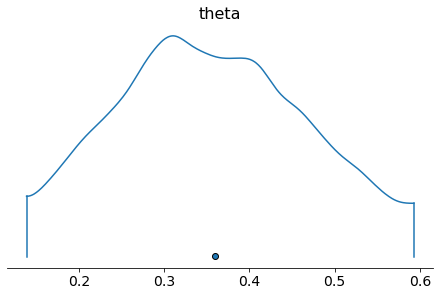

In [6]:
az.plot_density(fit, var_names=["theta"]);